In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import json

In [2]:
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUT_DATA ='train_input.npy'
TRAIN_LABEL_DATA ='train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [5]:
train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [13]:
model_name = 'cnn_classifier_en'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
         'vocab_size' : prepro_configs['vocab_size'],
         'embedding_size':128,
         'num_filters': 100,
         'dropout_rate': 0.5,
         'hidden_sdimension':250,
         'output_dimension':1}

In [14]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size']+1,
                                          output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                        kernel_size=kernel_size,padding='valid',
                                        activation='relu',
                                        kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                                        #가중치 값이 너무 커지지 않도록 제한한것
                          for kernel_size in [3, 4, 5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_sdimension'],
                                activation='relu',
                                kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                                activation='sigmoid',
                                kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    def call(self,x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x
                                        

In [16]:
model = CNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [21]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('{} -- Folder create complete \n'.format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor ='val_accuracy', verbose=1,
                             save_best_only=True, save_weights_only=True)


./data_out/cnn_classifier_en -- Folder already exists 



In [22]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 0.6668 - accuracy: 0.6082
Epoch 00001: val_accuracy improved from -inf to 0.77880, saving model to ./data_out/cnn_classifier_en\weights.h5
44/44 [==============================] - 32s 719ms/step - loss: 0.6668 - accuracy: 0.6082 - val_loss: 0.5406 - val_accuracy: 0.7788
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 0.3741 - accuracy: 0.8399
Epoch 00002: val_accuracy improved from 0.77880 to 0.87120, saving model to ./data_out/cnn_classifier_en\weights.h5
44/44 [==============================] - 33s 759ms/step - loss: 0.3741 - accuracy: 0.8399 - val_loss: 0.3131 - val_accuracy: 0.8712
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 0.2099 - accuracy: 0.9187
Epoch 00003: val_accuracy improved from 0.87120 to 0.88400, saving model to ./data_out/cnn_classifier_en\weights.h5
44/44 [==============================] - 34s 771ms/step - loss: 0.2099 - accuracy: 0.9187 - val_loss: 0.2990 

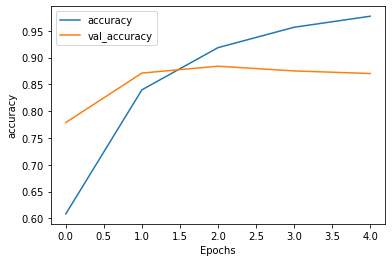

In [27]:
plot_graph(history,'accuracy')

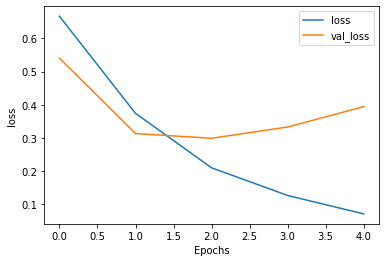

In [28]:
plot_graph(history,'loss')

In [29]:
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [30]:
SAVE_FILE_NM = 'weights.h5'#저장 되어있는 모델
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [32]:
predictions = model.predict(test_input, batch_size=5)
predictions = predictions.squeeze(-1)

In [34]:
import pandas as pd
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'),allow_pickle=True)
#allow_pickle=True 판다스 시리즈객체이므로 객체로 읽을때는 설정해줘야한다

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)
    
output = pd.DataFrame({'id': list(test_id), 'sentiment': list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv',index=False, quoting=3)